# Covid Data Preparation

## Imports and Files

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

PATH_COLLECTED_DATA = './computed/collected_data.csv'

## Read data from previously collected data
First we read the aggregated data from the notebook `collect_data.ipynb`. 

As a first step in data preparation, we take a look at missing values. In data collection, missing values often occur and we need to adress this. To see which features have plenty missing values, we create a heatmap with all features.

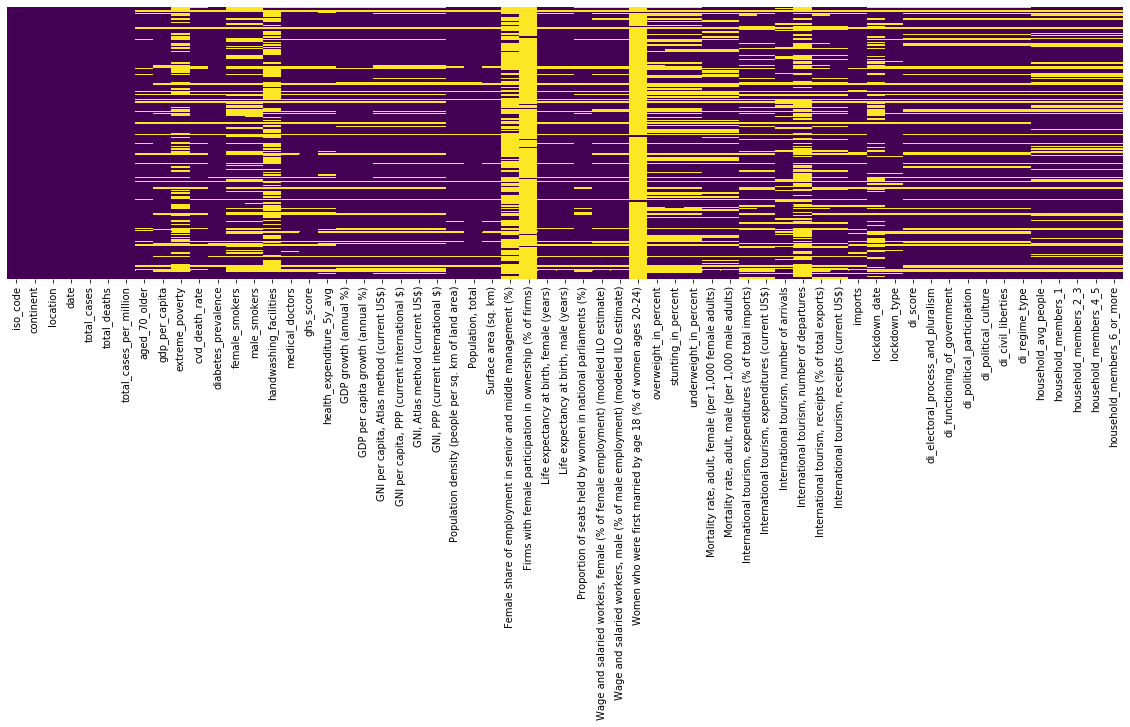

In [2]:
df = pd.read_csv(PATH_COLLECTED_DATA)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## Delete features with only a few entries
There are some features where many values are missing, which is indicated by the color yellow. If the feature is not a very important predictor for our target variables (total cases and death rate), we delete the feature completely.

In [3]:
df.drop(['Female share of employment in senior and middle management (%)',
         'Firms with female participation in ownership (% of firms)', 
         'Women who were first married by age 18 (% of women ages 20-24)', 
         'International tourism, number of departures', 
         'overweight_in_percent', 
         'stunting_in_percent', 
         'underweight_in_percent'],inplace=True, axis=1)

## Combine gender specific features into one
Some features differentiate between genders, for example there is a record for female and male smokers. For our purpose we do not need this differentiation, so we combine these records into one. For this we assume a sex ratio of 49.5% women to 50.5% men.

In [4]:
# see sex ratio at https://www.cia.gov/library/publications/resources/the-world-factbook/fields/351.html
FEMALE_RATIO = 0.495
MALE_RATIO = 1 - FEMALE_RATIO

df['smokers_percentage'] = FEMALE_RATIO * df['female_smokers'] + MALE_RATIO * df['male_smokers']
df['life_expectancy_at_birth'] = FEMALE_RATIO * df['Life expectancy at birth, female (years)'] + MALE_RATIO * df['Life expectancy at birth, male (years)']
df['wage_and_salaried_workers_percentage_employed'] = FEMALE_RATIO * df['Wage and salaried workers, female (% of female employment) (modeled ILO estimate)'] + MALE_RATIO * df['Wage and salaried workers, male (% of male employment) (modeled ILO estimate)']
df['mortality_rate_per_1000'] = FEMALE_RATIO * df['Mortality rate, adult, female (per 1,000 female adults)'] + MALE_RATIO * df['Mortality rate, adult, male (per 1,000 male adults)']

df.drop(['female_smokers', 'male_smokers', 'Life expectancy at birth, female (years)',
         'Life expectancy at birth, male (years)',
         'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)',
         'Wage and salaried workers, male (% of male employment) (modeled ILO estimate)',
         'Mortality rate, adult, female (per 1,000 female adults)',
         'Mortality rate, adult, male (per 1,000 male adults)'], inplace=True, axis=1)

In [5]:
df.to_csv('./computed/collected_data_combined_genders.csv', sep=',', encoding='utf-8', index=False)

## Investigate correlation of features with subscores
We also take a closer look at the correlations between the features. As there are several features on the topics *democracy* and *households*, the risk of correlation is very high. Therefore, we will first take a closer look on these features with their subscores and generate a correlation matrix. 

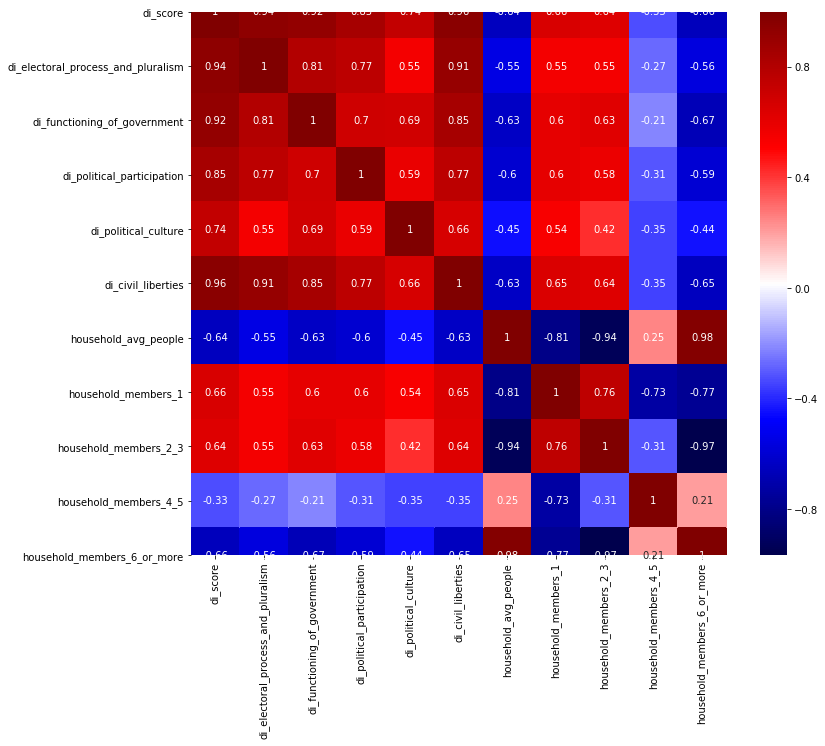

In [6]:
corr = df.loc[:, ['di_score', 'di_electoral_process_and_pluralism', 'di_functioning_of_government', 'di_political_participation', 'di_political_culture', 'di_civil_liberties', 'household_avg_people', 'household_members_1', 'household_members_2_3', 'household_members_4_5', 'household_members_6_or_more']].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="seismic")
plt.show()

Obviously the Democracy Index and it's subscores are strongly linked together.
Even the subscores have a strong correlation with each other.
Because of this we drop the subscores and keep only the aggregated score for now.

We also only keep the average of people per household because the more detailed numbers correlate and the average score should be sufficient.

In [7]:
df.drop(['di_electoral_process_and_pluralism', 'di_functioning_of_government', 'di_political_participation',
         'di_political_culture', 'di_civil_liberties', 'di_regime_type', 'household_members_1',
         'household_members_2_3', 'household_members_4_5', 'household_members_6_or_more'], inplace=True, axis=1)

## Investigate correlation among all features
After having handeled the strongly linked features, we will now investigate the correlations of all features. For this purpose we create a correlation matrix with all features left.

In [8]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases,total_deaths,total_cases_per_million,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,handwashing_facilities,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP growth (annual %),GDP per capita growth (annual %),"GNI per capita, Atlas method (current US$)","GNI per capita, PPP (current international $)","GNI, Atlas method (current US$)","GNI, PPP (current international $)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, expenditures (current US$)","International tourism, number of arrivals","International tourism, receipts (% of total exports)","International tourism, receipts (current US$)",imports,di_score,household_avg_people,smokers_percentage,life_expectancy_at_birth,wage_and_salaried_workers_percentage_employed,mortality_rate_per_1000
total_cases,1,0.93,0.2,0.13,0.16,-0.14,-0.11,0.046,0.13,0.08,0.34,0.3,-0.021,0.017,0.22,0.2,0.77,0.69,-0.027,0.31,0.59,-0.02,-0.017,0.53,0.49,-0.14,0.79,0.67,0.13,-0.15,0.013,0.13,0.15,-0.12
total_deaths,0.93,1,0.17,0.22,0.18,-0.15,-0.19,0.0011,0.17,0.11,0.41,0.38,-0.053,-0.0022,0.28,0.24,0.77,0.66,-0.037,0.25,0.45,0.072,-0.042,0.56,0.63,-0.13,0.84,0.72,0.2,-0.2,0.014,0.18,0.17,-0.1
total_cases_per_million,0.2,0.17,1,0.098,0.61,-0.32,-0.27,0.13,0.36,0.29,0.19,0.093,-0.066,-0.068,0.45,0.56,0.11,0.085,0.2,-0.046,0.047,0.013,0.21,0.12,0.11,-0.14,0.19,0.13,0.078,-0.31,0.023,0.35,0.37,-0.33
aged_70_older,0.13,0.22,0.098,1,0.49,-0.56,-0.34,-0.045,0.64,0.76,0.7,0.54,-0.14,0.19,0.61,0.6,0.22,0.18,0.031,-0.019,0.062,0.27,-0.067,0.24,0.42,-0.11,0.33,0.33,0.68,-0.79,0.49,0.71,0.63,-0.57
gdp_per_capita,0.16,0.18,0.61,0.49,1,-0.51,-0.47,0.26,0.65,0.57,0.53,0.21,-0.21,-0.082,0.89,0.98,0.2,0.16,0.29,-0.058,0.061,0.091,0.16,0.24,0.26,-0.15,0.31,0.32,0.45,-0.62,0.13,0.68,0.7,-0.56
extreme_poverty,-0.14,-0.15,-0.32,-0.56,-0.51,1,0.19,-0.45,-0.76,-0.6,-0.51,-0.099,0.18,-0.13,-0.4,-0.54,-0.13,-0.14,-0.027,-0.042,-0.12,-0.039,-0.016,-0.16,-0.27,-0.018,-0.18,-0.19,-0.44,0.46,-0.37,-0.76,-0.71,0.72
cvd_death_rate,-0.11,-0.19,-0.27,-0.34,-0.47,0.19,1,0.016,-0.043,-0.2,-0.42,-0.27,0.13,0.11,-0.53,-0.48,-0.16,-0.12,-0.18,0.0093,0.0032,-0.26,0.0024,-0.18,-0.26,-0.0023,-0.27,-0.24,-0.51,0.38,0.21,-0.47,-0.32,0.29
diabetes_prevalence,0.046,0.0011,0.13,-0.045,0.26,-0.45,0.016,1,0.57,0.072,-0.045,-0.18,-0.29,-0.2,0.064,0.21,0.051,0.072,0.14,0.022,-0.044,-0.2,0.2,0.023,-0.051,0.3,0.018,0.031,-0.086,-0.042,0.094,0.32,0.37,-0.48
handwashing_facilities,0.13,0.17,0.36,0.64,0.65,-0.76,-0.043,0.57,1,0.63,0.45,0.05,-0.085,0.14,0.64,0.74,0.16,0.14,0.093,0.041,-0.0023,0.0032,0.033,0.24,0.29,0.057,0.25,0.26,0.31,-0.29,0.39,0.83,0.73,-0.73
medical_doctors,0.08,0.11,0.29,0.76,0.57,-0.6,-0.2,0.072,0.63,1,0.49,0.39,-0.091,0.18,0.56,0.62,0.11,0.091,0.039,-0.066,0.058,0.27,0.1,0.15,0.2,-0.083,0.18,0.18,0.47,-0.63,0.48,0.71,0.68,-0.61


To effectively train our models we would like to keep all correlation coefficients below an absolute value of 0.5, thus we drop some features that correlate strongly with others.

In [9]:
df.drop(['GNI per capita, Atlas method (current US$)', 'GNI per capita, PPP (current international $)',
         'GNI, PPP (current international $)', 'GDP growth (annual %)', 'handwashing_facilities',
         'International tourism, expenditures (current US$)', 'International tourism, number of arrivals',
         'International tourism, receipts (current US$)', 'mortality_rate_per_1000',
         'life_expectancy_at_birth'], inplace=True, axis=1)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases,total_deaths,total_cases_per_million,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,di_score,household_avg_people,smokers_percentage,wage_and_salaried_workers_percentage_employed
total_cases,1,0.93,0.2,0.13,0.16,-0.14,-0.11,0.046,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,0.13,-0.15,0.013,0.15
total_deaths,0.93,1,0.17,0.22,0.18,-0.15,-0.19,0.0011,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,0.2,-0.2,0.014,0.17
total_cases_per_million,0.2,0.17,1,0.098,0.61,-0.32,-0.27,0.13,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,0.078,-0.31,0.023,0.37
aged_70_older,0.13,0.22,0.098,1,0.49,-0.56,-0.34,-0.045,0.76,0.7,0.54,0.19,0.22,0.031,-0.019,0.062,0.27,-0.067,-0.11,0.33,0.68,-0.79,0.49,0.63
gdp_per_capita,0.16,0.18,0.61,0.49,1,-0.51,-0.47,0.26,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,0.45,-0.62,0.13,0.7
extreme_poverty,-0.14,-0.15,-0.32,-0.56,-0.51,1,0.19,-0.45,-0.6,-0.51,-0.099,-0.13,-0.13,-0.027,-0.042,-0.12,-0.039,-0.016,-0.018,-0.19,-0.44,0.46,-0.37,-0.71
cvd_death_rate,-0.11,-0.19,-0.27,-0.34,-0.47,0.19,1,0.016,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,-0.51,0.38,0.21,-0.32
diabetes_prevalence,0.046,0.0011,0.13,-0.045,0.26,-0.45,0.016,1,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,-0.086,-0.042,0.094,0.37
medical_doctors,0.08,0.11,0.29,0.76,0.57,-0.6,-0.2,0.072,1,0.49,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,0.47,-0.63,0.48,0.68
ghs_score,0.34,0.41,0.19,0.7,0.53,-0.51,-0.42,-0.045,0.49,1,0.49,0.21,0.37,0.071,0.13,0.25,0.26,-0.025,-0.33,0.51,0.67,-0.62,0.26,0.54


For deciding which feature to delete when two correlate strongly, we also take the number of missing values (for that feature) into account.

(209, 30)


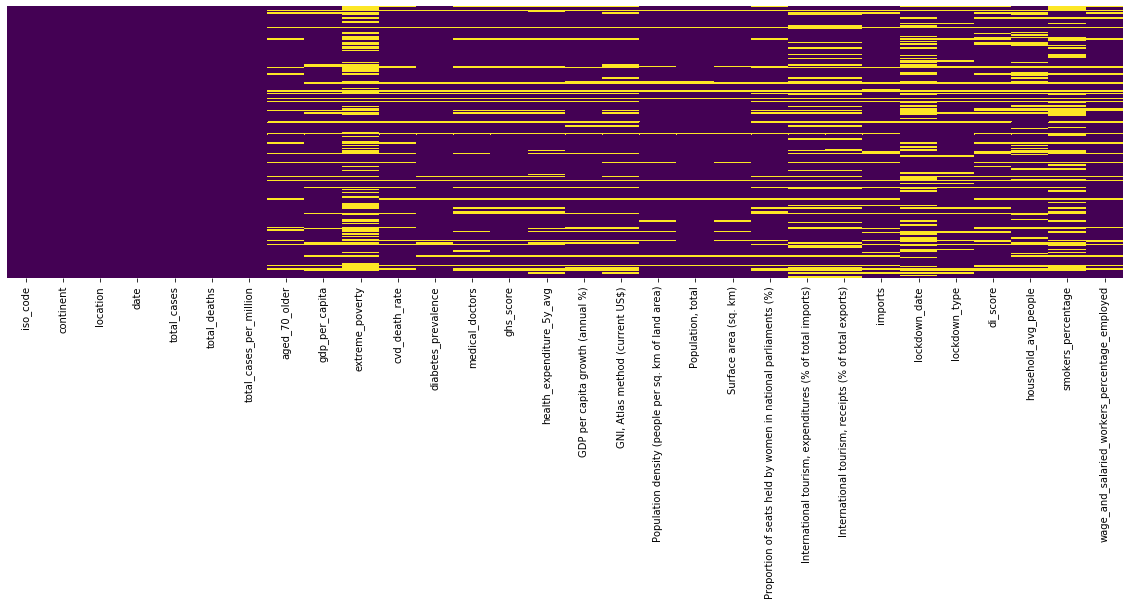

In [10]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

Considering the number of missing values, we now delete more features with high correlations.`Extreme_poverty`, `aged_70_older` and `di_score` are features that show high correlations and have more missing values compared to the other features.

In [11]:
df.drop(['extreme_poverty', 'aged_70_older', 'di_score'], inplace=True, axis=1)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases,total_deaths,total_cases_per_million,gdp_per_capita,cvd_death_rate,diabetes_prevalence,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,household_avg_people,smokers_percentage,wage_and_salaried_workers_percentage_employed
total_cases,1,0.93,0.2,0.16,-0.11,0.046,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,-0.15,0.013,0.15
total_deaths,0.93,1,0.17,0.18,-0.19,0.0011,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,-0.2,0.014,0.17
total_cases_per_million,0.2,0.17,1,0.61,-0.27,0.13,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,-0.31,0.023,0.37
gdp_per_capita,0.16,0.18,0.61,1,-0.47,0.26,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,-0.62,0.13,0.7
cvd_death_rate,-0.11,-0.19,-0.27,-0.47,1,0.016,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,0.38,0.21,-0.32
diabetes_prevalence,0.046,0.0011,0.13,0.26,0.016,1,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,-0.042,0.094,0.37
medical_doctors,0.08,0.11,0.29,0.57,-0.2,0.072,1,0.49,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,-0.63,0.48,0.68
ghs_score,0.34,0.41,0.19,0.53,-0.42,-0.045,0.49,1,0.49,0.21,0.37,0.071,0.13,0.25,0.26,-0.025,-0.33,0.51,-0.62,0.26,0.54
health_expenditure_5y_avg,0.3,0.38,0.093,0.21,-0.27,-0.18,0.39,0.49,1,-0.018,0.33,-0.055,-0.075,0.1,0.29,-0.051,-0.15,0.36,-0.43,0.19,0.34
GDP per capita growth (annual %),0.017,-0.0022,-0.068,-0.082,0.11,-0.2,0.18,0.21,-0.018,1,0.063,0.016,0.16,0.022,0.0096,-0.17,0.087,0.082,-0.24,0.16,0.027


### Create CSV
The correlation matrix of the features is now improved. Further feature removal depends on what we want to predict, so we save the current data and proceed in other notebooks.

In [12]:
df.to_csv('./computed/collected_data_reduced_features.csv', sep=',', encoding='utf-8', index=False)